In [ ]:
! pip install torch_geometric

In [ ]:
import pandas as pd
def top_k_movies(k):
  data = pd.read_csv('u.data', sep='\t', header=None, names=['Rater_ID', 'Movie_ID', 'Rating', 'Timestamp'])

  # Count the number of raters per movie
  rating_counts = data['Movie_ID'].value_counts()

  # Determine k, the number of top rated movies you want to see
  k = k  # Change this value to whatever number of top movies you want to list

  # Get the top k movies with the most raters
  top_k_movies = rating_counts.head(k).index.tolist()
  # Display the results
  print("Top", k, "movies with the most raters:")
  print(top_k_movies)
  return top_k_movies

In [ ]:
movie = top_k_movies(1)

Top 1 movies with the most raters:
[50]


In [ ]:
import numpy as np
import os
import zipfile # To handle zip files
import torch as torch
import torch.optim as optim
def load_data(movie, min_ratings):

    # Extract all from zip file
    dataDir=os.getcwd()
    zipObject = zipfile.ZipFile(os.path.join(dataDir,'ml-100k.zip'))
    zipObject.extractall(dataDir)
    zipObject.close()

    rawDataFilename = os.path.join(dataDir,'ml-100k','u.data')

    # Initialize rating matrix
    rawMatrix = np.empty([0, 0])

    # From each row of u.data, extract userID, movieID and rating
    with open(rawDataFilename, 'r') as rawData:
        for dataLine in rawData:
            dataLineSplit = dataLine.rstrip('\n').split('\t')
            userID = int(dataLineSplit[0])
            movieID = int(dataLineSplit[1])
            rating = int(dataLineSplit[2])
            if userID > rawMatrix.shape[0]:
                rowDiff = userID - rawMatrix.shape[0]
                zeroPadRows = np.zeros([rowDiff, rawMatrix.shape[1]])
                rawMatrix = np.concatenate((rawMatrix, zeroPadRows),
                                           axis = 0)
            if movieID > rawMatrix.shape[1]:
                colDiff = movieID - rawMatrix.shape[1]
                zeroPadCols = np.zeros([rawMatrix.shape[0], colDiff])
                rawMatrix = np.concatenate((rawMatrix, zeroPadCols),
                                           axis = 1)

            # Assign rating to rating matrix
            rawMatrix[userID - 1, movieID - 1] = rating

    # Define X
    X = rawMatrix

    # Count number of ratings per column, i.e., per movie
    nbRatingsCols = np.sum(X>0,axis=0)

    # Mask to identify movies with at least min_ratings
    mask = nbRatingsCols >= min_ratings

    idxMovie = []
    for i in movie:
    # Save new index of the input argument "movie"
      idxMovie.append(np.sum(mask[0:i])-1)

    # Remove matrix columns
    idx = np.argwhere(mask>0).squeeze()
    X = X[:,idx.squeeze()]

    # Make sure there are no rows of all zeros
    nbRatingsRows = np.sum(X>0,axis=1)
    idx = np.argwhere(nbRatingsRows>0).squeeze()
    X=X[idx,:]

    # Return cleaned-up X and new index of input argument "movie"
    return X, idxMovie

In [ ]:
def check(idxContact, user):
  # Extract all from zip file
    dataDir=os.getcwd()
    zipObject = zipfile.ZipFile(os.path.join(dataDir,'ml-100k.zip'))
    zipObject.extractall(dataDir)
    zipObject.close()

    rawDataFilename = os.path.join(dataDir,'ml-100k','u.data')

    # Initialize rating matrix
    rawMatrix = np.empty([0, 0])

    # From each row of u.data, extract userID, movieID and rating
    with open(rawDataFilename, 'r') as rawData:
        for dataLine in rawData:
            dataLineSplit = dataLine.rstrip('\n').split('\t')
            userID = int(dataLineSplit[0])
            movieID = int(dataLineSplit[1])
            rating = int(dataLineSplit[2])
            if (movieID == idxContact) and (userID == user):
              return rating

In [ ]:
X, idxContact = load_data(movie=movie, min_ratings=10)

In [ ]:
def create_graph(X, idxTrain, knn):

    # Everything below 1e-9 is considered zero
    zeroTolerance = 1e-9

    # Number of nodes is equal to the number of columns (movies)
    N = X.shape[1]

    # Isolating users used for training
    XTrain = np.transpose(X[idxTrain,:])

    # Calculating correlation matrix
    binaryTemplate = (XTrain > 0).astype(XTrain.dtype)
    sumMatrix = XTrain.dot(binaryTemplate.T)
    countMatrix = binaryTemplate.dot(binaryTemplate.T)
    countMatrix[countMatrix == 0] = 1
    avgMatrix = sumMatrix / countMatrix
    sqSumMatrix = XTrain.dot(XTrain.T)
    correlationMatrix = sqSumMatrix / countMatrix - avgMatrix * avgMatrix.T

    # Normalizing by diagonal weights
    sqrtDiagonal = np.sqrt(np.diag(correlationMatrix))
    nonzeroSqrtDiagonalIndex = (sqrtDiagonal > zeroTolerance)\
                                                 .astype(sqrtDiagonal.dtype)
    sqrtDiagonal[sqrtDiagonal < zeroTolerance] = 1.
    invSqrtDiagonal = 1/sqrtDiagonal
    invSqrtDiagonal = invSqrtDiagonal * nonzeroSqrtDiagonalIndex
    normalizationMatrix = np.diag(invSqrtDiagonal)

    # Zero-ing the diagonal
    normalizedMatrix = normalizationMatrix.dot(
                            correlationMatrix.dot(normalizationMatrix)) \
                            - np.eye(correlationMatrix.shape[0])

    # Keeping only edges with weights above the zero tolerance
    normalizedMatrix[np.abs(normalizedMatrix) < zeroTolerance] = 0.
    W = normalizedMatrix

    # Sparsifying the graph
    WSorted = np.sort(W,axis=1)
    threshold = WSorted[:,-knn].squeeze()
    thresholdMatrix = (np.tile(threshold,(N,1))).transpose()
    W[W<thresholdMatrix] = 0

    # Normalizing by eigenvalue with largest magnitude
    E, V = np.linalg.eig(W)
    W = W/np.max(np.abs(E))

    return W

In [ ]:
# Creating and sparsifying the graph
nTotal = X.shape[0] # total number of users (samples)
permutation = np.random.permutation(nTotal)
nTrain = int(np.ceil(0.9*nTotal)) # number of training samples
idxTrain = permutation[0:nTrain] # indices of training samples
nTest = nTotal-nTrain # number of test samples
idxTest=permutation[nTrain:nTotal] # indices of test samples

In [ ]:
N = X.shape[1]
W = create_graph(X=X, idxTrain=idxTrain, knn=40)

In [ ]:
import torch

# Example adjacency matrix W

# Convert the numpy matrix to a torch tensor if it's not already one
W = torch.tensor(W, dtype=torch.float)

# Get the indices of non-zero entries
src, dst = torch.nonzero(W, as_tuple=True)

# Get the corresponding weights
weights = W[src, dst].float()


In [ ]:
edge_index = torch.stack([src, dst], dim=0).long()
edge_index

tensor([[   0,    0,    0,  ..., 1151, 1151, 1151],
        [  34,  108,  122,  ..., 1057, 1063, 1087]])

In [ ]:
def split_data(X, idxTrain, idxTest, idxMovie):
    N = X.shape[1]

    # Training data preparation
    xTrain = X[idxTrain, :]
    # Find rows where all idxMovie columns have nonzero values
    nonzero_condition_train = (xTrain[:, idxMovie] > 0).all(axis=1)
    idx_train = np.argwhere(nonzero_condition_train).squeeze()
    xTrain = xTrain[idx_train, :]
    yTrain = np.zeros(xTrain.shape)
    yTrain[:, idxMovie] = xTrain[:, idxMovie]
    xTrain[:, idxMovie] = 0
    xTrain = torch.tensor(xTrain)
    xTrain = xTrain.reshape([-1, 1, N])
    yTrain = torch.tensor(yTrain)
    yTrain = yTrain.reshape([-1, 1, N])

    # Testing data preparation
    xTest = X[idxTest, :]
    nonzero_condition_test = (xTest[:, idxMovie] > 0).all(axis=1)
    idx_test = np.argwhere(nonzero_condition_test).squeeze()
    xTest = xTest[idx_test, :]
    yTest = np.zeros(xTest.shape)
    yTest[:, idxMovie] = xTest[:, idxMovie]
    xTest[:, idxMovie] = 0
    xTest = torch.tensor(xTest, dtype=torch.float)
    xTest = xTest.reshape([-1, 1, N])
    yTest = torch.tensor(yTest, dtype=torch.float)
    yTest = yTest.reshape([-1, 1, N])

    return xTrain, yTrain, xTest, yTest


In [ ]:
xTrain, yTrain, xTest, yTest = split_data(X, idxTrain, idxTest, idxContact)
nTrain = xTrain.shape[0]
nTest = xTest.shape[0]

In [ ]:
import torch.nn as nn
def movieMSELoss(yHat,y,idxMovie):
  mse = nn.MSELoss()
  return mse(yHat[idxMovie],y[idxMovie])

In [ ]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

class RatingGNN(torch.nn.Module):
    def __init__(self):
        super(RatingGNN, self).__init__()
        self.conv1 = GCNConv(1, 32)  # Example size; adjust as needed
        self.conv2 = GCNConv(32, 1)

    def forward(self, x, edge_index, edge_weight):
        x = torch.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [ ]:
def Train_model(model,epochs,optimizer,criterion,device,idxContact, xTrain, yTrain, xTest, yTest,edge_index,weights,batch_size):
    """
    model: input model
    epochs: training epoch number
    optimizer: the optimizer
    criterion: the criterion for the loss

"""
    model.to(device)
    train_data_list = [Data(x=xTrain[i].reshape([-1,1]).float(), edge_index=edge_index, edge_attr=weights, y=yTrain[i].reshape([-1,1]).float()) for i in range(len(xTrain))]
    test_data_list = [Data(x=xTest[i].reshape([-1,1]).float(), edge_index=edge_index, edge_attr=weights, y=yTest[i].reshape([-1,1]).float()) for i in range(len(xTest))]

    # Create DataLoaders for batch processing
    train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      for data in train_loader:
        data = data.to(device)
        inputs, labels = data.x, data.y
        optimizer.zero_grad()

        outputs = model(inputs,data.edge_index, data.edge_attr)
        loss = criterion(outputs, labels, idxContact)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.data
      train_loss = running_loss / len(xTrain)
      train_mse = np.sqrt(train_loss)

    # Validation loop
      model.eval()
      val_running_loss = 0.0
      with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            inputs, labels = data.x, data.y
            outputs = model(inputs,data.edge_index, data.edge_attr)
            loss = criterion(outputs, labels, idxContact)
            val_running_loss += loss.item()
            predicted = outputs.data

      val_loss = val_running_loss / len(xTest)
      val_mse = np.sqrt(val_loss)

    return val_mse



In [ ]:
# Set your training settings
# Model instantiation and forward pass
model = RatingGNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#epochs = 20 #data type: int
#lr = 0.0005 #data type: float
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion= movieMSELoss

# Training
#net = Train_model(model, epochs, optimizer, criterion, device, idxContact, xTrain, yTrain, xTest, yTest,edge_index,weights,6)

In [ ]:
import numpy as np
from numpy.linalg import pinv

def calculate_leverage_scores(X):
    # Compute the projection matrix P
    P = X @ pinv(X.T @ X) @ X.T
    # Leverage scores are the diagonal elements of the projection matrix
    leverage_scores = np.diag(P)
    return leverage_scores

def resample_matrix(X, leverage_scores, fraction, W , idxContact):
    # Calculate the number of samples to select
    num_samples = int(X.shape[0] * fraction)
    # Use leverage scores as probabilities to sample indices
    np.random.seed(20)
    sampled_indices = np.random.choice(X.shape[0], size=num_samples, replace=False, p=leverage_scores/leverage_scores.sum())
    for idx in idxContact:
      if idx not in sampled_indices:
        sampled_indices = np.append(sampled_indices, idx)
    sampled_indices.sort()
    positions = [np.where(sampled_indices == idx)[0][0] for idx in idxContact]

    return X[sampled_indices], sampled_indices, W[np.ix_(sampled_indices, sampled_indices)], positions

In [ ]:
X_T_train = X[idxTrain].transpose()
leverage_scores = calculate_leverage_scores(X_T_train)
X_T = X.transpose()
# Resample at 20%, 40%, 60%, and 80%
X_20_T, id_20, W20, idxContact20= resample_matrix(X_T, leverage_scores, 0.20, W, idxContact)
X_40_T, id_40, W40, idxContact40 = resample_matrix(X_T, leverage_scores, 0.40, W, idxContact)
X_60_T, id_60, W60, idxContact60 = resample_matrix(X_T, leverage_scores, 0.60, W, idxContact)
X_80_T, id_80, W80, idxContact80 = resample_matrix(X_T, leverage_scores, 0.80, W, idxContact)

Fitted exponential function parameters: a = 1.6563, b = -3.9012


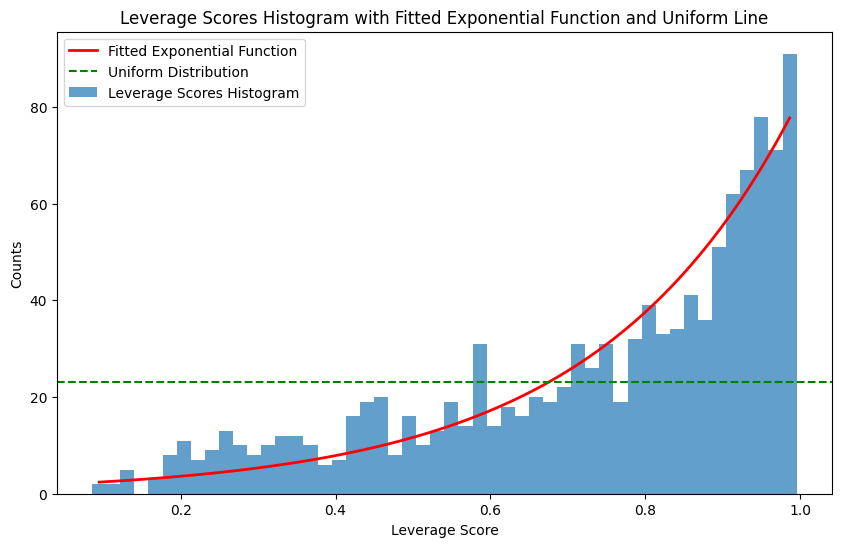

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from scipy.optimize import curve_fit


def exponential_func(x, a, b):
    return a * np.exp(-b * x)

# Assuming X_T_train is your transposed training data matrix
X_T_train = X[idxTrain].T
leverage_scores = calculate_leverage_scores(X_T_train)

# Plotting the histogram and fitting an exponential function
plt.figure(figsize=(10, 6))
counts, bin_edges = np.histogram(leverage_scores, bins=50)

# Compute the bin centers from bin edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Only consider bins with non-zero counts for fitting
nonzero_indices = counts > 0
counts_nonzero = counts[nonzero_indices]
bin_centers_nonzero = bin_centers[nonzero_indices]

# Fit the exponential function to the histogram counts
popt, pcov = curve_fit(exponential_func, bin_centers_nonzero, counts_nonzero, maxfev=10000)
a_fit, b_fit = popt
print(f"Fitted exponential function parameters: a = {a_fit:.4f}, b = {b_fit:.4f}")

# Generate x values for plotting the fitted function
x_fit = np.linspace(np.min(bin_centers_nonzero), np.max(bin_centers_nonzero), 100)
y_fit = exponential_func(x_fit, *popt)

# Plot the histogram
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.7, label='Leverage Scores Histogram')

# Overlay the fitted exponential function
plt.plot(x_fit, y_fit, 'r-', lw=2, label='Fitted Exponential Function')

# Calculate the uniform line (average count per bin)
total_counts = np.sum(counts)
num_bins = len(bin_centers)
uniform_count = total_counts / num_bins

# Draw the uniform line
plt.axhline(y=uniform_count, color='g', linestyle='--', label='Uniform Distribution')

plt.xlabel('Leverage Score')
plt.ylabel('Counts')
plt.title('Leverage Scores Histogram with Fitted Exponential Function and Uniform Line')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# Predicted counts from the exponential fit
counts_predicted = exponential_func(bin_centers_nonzero, *popt)

# Compute R-squared
r_squared = r2_score(counts_nonzero, counts_predicted)
print(f"R-squared of exponential fit: {r_squared:.4f}")


R-squared of exponential fit: 0.9071


In [ ]:
X_20 = X_20_T.transpose()
X_40 = X_40_T.transpose()
X_60 = X_60_T.transpose()
X_80 = X_80_T.transpose()

In [ ]:
xTrain20, yTrain20, xTest20, yTest20 = split_data(X_20, idxTrain, idxTest, idxContact20)
xTrain40, yTrain40, xTest40, yTest40 = split_data(X_40, idxTrain, idxTest, idxContact40)
xTrain60, yTrain60, xTest60, yTest60 = split_data(X_60, idxTrain, idxTest, idxContact60)
xTrain80, yTrain80, xTest80, yTest80 = split_data(X_80, idxTrain, idxTest, idxContact80)

In [ ]:
parameter_grid = {
    'learning_rate': [0.0005, 0.001],
    'epochs': [18, 20, 22],
    'batch_size': [4,6, 8],
}

In [ ]:
test_result = {}
# Perform grid search
for pct in [20, 40, 60, 80]:
    best_params = None
    best_val_mse = float('inf')
    val_mse_list = []  # Store validation MSE for iterations with best hyperparameters

    for lr in parameter_grid['learning_rate']:
        for epoch in parameter_grid['epochs']:
            for batch in parameter_grid['batch_size']:
                avg_val_mse = 0.0  # Average over 10 iterations

                for j in range(3):
                    # Fetch data dynamically
                    xTrain_var = eval(f'xTrain{pct}')
                    yTrain_var = eval(f'yTrain{pct}')
                    xTest_var = eval(f'xTest{pct}')
                    yTest_var = eval(f'yTest{pct}')
                    idxContact_var = eval(f'idxContact{pct}')
                    W_var = eval(f'W{pct}')

                    # Prepare graph
                    W = torch.tensor(W_var, dtype=torch.float)
                    src, dst = torch.nonzero(W, as_tuple=True)
                    weights = W[src, dst].float()
                    edge_index = torch.stack([src, dst], dim=0).long()

                    # Initialize model and optimizer
                    model = RatingGNN()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = movieMSELoss

                    # Train model and get validation MSE
                    val_mse = Train_model(
                        model=model,
                        epochs=epoch,
                        optimizer=optimizer,
                        criterion=criterion,
                        device=device,
                        idxContact=idxContact_var,
                        xTrain=xTrain_var,
                        yTrain=yTrain_var,
                        xTest=xTest_var,
                        yTest=yTest_var,
                        edge_index=edge_index,
                        weights=weights,
                        batch_size=batch
                    )
                    avg_val_mse += val_mse

                avg_val_mse /= 5  # Compute average over 10 iterations

                # Update best hyperparameters if needed
                if avg_val_mse < best_val_mse:
                    best_val_mse = avg_val_mse
                    best_params = {
                        'learning_rate': lr,
                        'epochs': epoch,
                        'batch_size': batch
                    }
                    val_mse_list = [val_mse]

    # Print and store best parameters and validation performance
    print(f'Best parameters for {pct}%: {best_params}')
    print(f'Best validation MSE for {pct}%: {best_val_mse}')
    for k in range(10):
      # Perform final test and store results
      xTrain_var = eval(f'xTrain{pct}')
      yTrain_var = eval(f'yTrain{pct}')
      xTest_var = eval(f'xTest{pct}')
      yTest_var = eval(f'yTest{pct}')
      idxContact_var = eval(f'idxContact{pct}')
      W_var = eval(f'W{pct}')
      W = torch.tensor(W_var, dtype=torch.float)
      src, dst = torch.nonzero(W, as_tuple=True)
      weights = W[src, dst].float()
      edge_index = torch.stack([src, dst], dim=0).long()

      final_model = RatingGNN()
      optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
      criterion = movieMSELoss

      Train_model(
          model=final_model,
          epochs=best_params['epochs'],
          optimizer=optimizer,
          criterion=criterion,
          device=device,
          idxContact=idxContact_var,
          xTrain=xTrain_var,
          yTrain=yTrain_var,
          xTest=xTest_var,
          yTest=yTest_var,
          edge_index=edge_index,
          weights=weights,
          batch_size=best_params['batch_size']
      )

      W = create_graph(X=X, idxTrain=idxTrain, knn=40)

      W = torch.tensor(W, dtype=torch.float)

      # Get the indices of non-zero entries
      src, dst = torch.nonzero(W, as_tuple=True)

      # Get the corresponding weights
      weights = W[src, dst].float()
      edge_index = torch.stack([src, dst], dim=0).long()

      test_data_list = [Data(x=xTest[i].reshape([-1,1]).float(), edge_index=edge_index, edge_attr=weights, y=yTest[i].reshape([-1,1]).float()) for i in range(len(xTest))]
      test_loader = DataLoader(test_data_list, batch_size=best_params['batch_size'], shuffle=False)

      mod = final_model
      mod.eval()
      val_running_loss = 0.0
      with torch.no_grad():
        for data in test_loader:
          data = data.to(device)
          inputs, labels = data.x, data.y
          outputs = mod(inputs,data.edge_index, data.edge_attr)
          loss = criterion(outputs, labels, idxContact)
          val_running_loss += loss.item()

      val_loss = val_running_loss / len(xTest)
      val_mse = np.sqrt(val_loss)

      print(f'Final test MSE for {pct}%: {val_mse}')
      if pct in test_result:
          test_result[pct].append(val_mse)
      else:
          test_result[pct] = [val_mse]


<ipython-input-57-4446139a8a21>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W_var, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Best parameters for 20%: {'learning_rate': 0.0005, 'epochs': 18, 'batch_size': 6}
Best validation MSE for 20%: 0.19666548992660574


<ipython-input-57-4446139a8a21>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W_var, dtype=torch.float)


Final test MSE for 20%: 0.364364265652096
Final test MSE for 20%: 0.32950576007172955
Final test MSE for 20%: 0.3252544206316337
Final test MSE for 20%: 0.33595305443911433
Final test MSE for 20%: 0.3327360154450877
Final test MSE for 20%: 0.3325440463867753
Final test MSE for 20%: 0.343984413173504
Final test MSE for 20%: 0.350896233816252
Final test MSE for 20%: 0.3625701051277041
Final test MSE for 20%: 0.35045599339436434
Best parameters for 40%: {'learning_rate': 0.001, 'epochs': 20, 'batch_size': 6}
Best validation MSE for 40%: 0.17537961395909857
Final test MSE for 40%: 0.3075899557114259
Final test MSE for 40%: 0.3023321105668076
Final test MSE for 40%: 0.3072492131314086
Final test MSE for 40%: 0.2968602696219296
Final test MSE for 40%: 0.30389706833479646
Final test MSE for 40%: 0.31088062343028006
Final test MSE for 40%: 0.3461175611371831
Final test MSE for 40%: 0.2940239372638141
Final test MSE for 40%: 0.3136049877038386
Final test MSE for 40%: 0.3029158827434344
Best par

{20: 0.3428264308138261, 40: 0.30854716096449186, 60: 0.3065017968542427, 80: 0.29914608721955127}


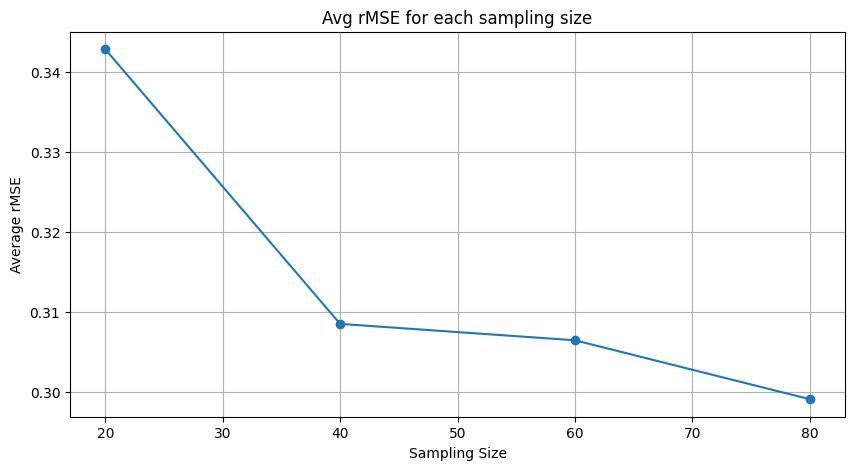

In [ ]:
averages = {}  # This will store the average for each key

for key, values in test_result.items():
    average = sum(values) / len(values)  # Calculate the average
    averages[key] = average  # Store the average in the new dictionary

print(averages)

import matplotlib.pyplot as plt

# Prepare the data for plotting
keys = list(averages.keys())
values = list(averages.values())

# Creating the line graph
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(keys, values, marker='o')  # Plot lines with markers at each data point
plt.title('Avg rMSE for each sampling size')  # Add a title
plt.xlabel('Sampling Size')  # X-axis label
plt.ylabel('Average rMSE')  # Y-axis label
plt.grid(True)  # Turn on the grid
plt.show()  # Display the plot



### Random Sampling

In [ ]:
def random_resample_matrix(X, fraction, W , idxContact):
    # Calculate the number of samples to select
    num_samples = int(X.shape[0] * fraction)
    # Use leverage scores as probabilities to sample indices
    np.random.seed(20)
    sampled_indices = np.random.choice(X.shape[0], size=num_samples, replace=False)
    for idx in idxContact:
      if idx not in sampled_indices:
        sampled_indices = np.append(sampled_indices, idx)
    sampled_indices.sort()
    positions = [np.where(sampled_indices == idx)[0][0] for idx in idxContact]

    return X[sampled_indices], sampled_indices, W[np.ix_(sampled_indices, sampled_indices)], positions

In [ ]:
X_T_train = X[idxTrain].transpose()
X_T = X.transpose()
# Resample at 20%, 40%, 60%, and 80%
X_20_T, id_20, W20, idxContact20= random_resample_matrix(X_T, 0.20, W, idxContact)
X_40_T, id_40, W40, idxContact40 = random_resample_matrix(X_T, 0.40, W, idxContact)
X_60_T, id_60, W60, idxContact60 = random_resample_matrix(X_T, 0.60, W, idxContact)
X_80_T, id_80, W80, idxContact80 = random_resample_matrix(X_T, 0.80, W, idxContact)

X_20 = X_20_T.transpose()
X_40 = X_40_T.transpose()
X_60 = X_60_T.transpose()
X_80 = X_80_T.transpose()

xTrain20, yTrain20, xTest20, yTest20 = split_data(X_20, idxTrain, idxTest, idxContact20)
xTrain40, yTrain40, xTest40, yTest40 = split_data(X_40, idxTrain, idxTest, idxContact40)
xTrain60, yTrain60, xTest60, yTest60 = split_data(X_60, idxTrain, idxTest, idxContact60)
xTrain80, yTrain80, xTest80, yTest80 = split_data(X_80, idxTrain, idxTest, idxContact80)

In [ ]:
test_result2 = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Perform grid search
for pct in [20, 40, 60, 80]:
    best_params = None
    best_val_mse = float('inf')
    val_mse_list = []  # Store validation MSE for iterations with best hyperparameters

    for lr in parameter_grid['learning_rate']:
        for epoch in parameter_grid['epochs']:
            for batch in parameter_grid['batch_size']:
                avg_val_mse = 0.0  # Average over 10 iterations

                for j in range(3):
                    # Fetch data dynamically
                    xTrain_var = eval(f'xTrain{pct}')
                    yTrain_var = eval(f'yTrain{pct}')
                    xTest_var = eval(f'xTest{pct}')
                    yTest_var = eval(f'yTest{pct}')
                    idxContact_var = eval(f'idxContact{pct}')
                    W_var = eval(f'W{pct}')

                    # Prepare graph
                    W = torch.tensor(W_var, dtype=torch.float)
                    src, dst = torch.nonzero(W, as_tuple=True)
                    weights = W[src, dst].float()
                    edge_index = torch.stack([src, dst], dim=0).long()

                    # Initialize model and optimizer
                    model = RatingGNN()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = movieMSELoss

                    # Train model and get validation MSE
                    val_mse = Train_model(
                        model=model,
                        epochs=epoch,
                        optimizer=optimizer,
                        criterion=criterion,
                        device=device,
                        idxContact=idxContact_var,
                        xTrain=xTrain_var,
                        yTrain=yTrain_var,
                        xTest=xTest_var,
                        yTest=yTest_var,
                        edge_index=edge_index,
                        weights=weights,
                        batch_size=batch
                    )
                    avg_val_mse += val_mse

                avg_val_mse /= 5  # Compute average over 10 iterations

                # Update best hyperparameters if needed
                if avg_val_mse < best_val_mse:
                    best_val_mse = avg_val_mse
                    best_params = {
                        'learning_rate': lr,
                        'epochs': epoch,
                        'batch_size': batch
                    }
                    val_mse_list = [val_mse]

    # Print and store best parameters and validation performance
    print(f'Best parameters for {pct}%: {best_params}')
    print(f'Best validation MSE for {pct}%: {best_val_mse}')
    for k in range(10):
      # Perform final test and store results
      xTrain_var = eval(f'xTrain{pct}')
      yTrain_var = eval(f'yTrain{pct}')
      xTest_var = eval(f'xTest{pct}')
      yTest_var = eval(f'yTest{pct}')
      idxContact_var = eval(f'idxContact{pct}')
      W_var = eval(f'W{pct}')
      W = torch.tensor(W_var, dtype=torch.float)
      src, dst = torch.nonzero(W, as_tuple=True)
      weights = W[src, dst].float()
      edge_index = torch.stack([src, dst], dim=0).long()

      final_model = RatingGNN()
      optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
      criterion = movieMSELoss

      Train_model(
          model=final_model,
          epochs=best_params['epochs'],
          optimizer=optimizer,
          criterion=criterion,
          device=device,
          idxContact=idxContact_var,
          xTrain=xTrain_var,
          yTrain=yTrain_var,
          xTest=xTest_var,
          yTest=yTest_var,
          edge_index=edge_index,
          weights=weights,
          batch_size=best_params['batch_size']
      )

      W = create_graph(X=X, idxTrain=idxTrain, knn=40)

      W = torch.tensor(W, dtype=torch.float)

      # Get the indices of non-zero entries
      src, dst = torch.nonzero(W, as_tuple=True)

      # Get the corresponding weights
      weights = W[src, dst].float()
      edge_index = torch.stack([src, dst], dim=0).long()

      test_data_list = [Data(x=xTest[i].reshape([-1,1]).float(), edge_index=edge_index, edge_attr=weights, y=yTest[i].reshape([-1,1]).float()) for i in range(len(xTest))]
      test_loader = DataLoader(test_data_list, batch_size=best_params['batch_size'], shuffle=False)

      mod = final_model
      mod.eval()
      val_running_loss = 0.0
      with torch.no_grad():
        for data in test_loader:
          data = data.to(device)
          inputs, labels = data.x, data.y
          outputs = mod(inputs,data.edge_index, data.edge_attr)
          loss = criterion(outputs, labels, idxContact)
          val_running_loss += loss.item()

      val_loss = val_running_loss / len(xTest)
      val_mse = np.sqrt(val_loss)

      print(f'Final test MSE for {pct}%: {val_mse}')
      if pct in test_result2:
          test_result2[pct].append(val_mse)
      else:
          test_result2[pct] = [val_mse]


<ipython-input-61-6d76acf12a7a>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W_var, dtype=torch.float)


Best parameters for 20%: {'learning_rate': 0.001, 'epochs': 18, 'batch_size': 6}
Best validation MSE for 20%: 0.20484023277162983


<ipython-input-61-6d76acf12a7a>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W_var, dtype=torch.float)


Final test MSE for 20%: 0.31758041781971635
Final test MSE for 20%: 0.3444122414448664
Final test MSE for 20%: 0.3269223803552649
Final test MSE for 20%: 0.3099436662320672
Final test MSE for 20%: 0.33465067945945676
Final test MSE for 20%: 0.3497185003247379
Final test MSE for 20%: 0.34555836594159334
Final test MSE for 20%: 0.3279030402296277
Final test MSE for 20%: 0.32863070582389514
Final test MSE for 20%: 0.32658212381764223
Best parameters for 40%: {'learning_rate': 0.001, 'epochs': 20, 'batch_size': 6}
Best validation MSE for 40%: 0.1782126478250226
Final test MSE for 40%: 0.401737876026873
Final test MSE for 40%: 0.3311750354181354
Final test MSE for 40%: 0.3675270440372722
Final test MSE for 40%: 0.36778028905642496
Final test MSE for 40%: 0.35915280242001424
Final test MSE for 40%: 0.37139505219200886
Final test MSE for 40%: 0.3573499826849556
Final test MSE for 40%: 0.34521982785219407
Final test MSE for 40%: 0.39724803494157224
Final test MSE for 40%: 0.3854910632956003
Be

{20: 0.34619021214488677, 40: 0.3684077007925051, 60: 0.30379072881853897, 80: 0.30362554739474745}


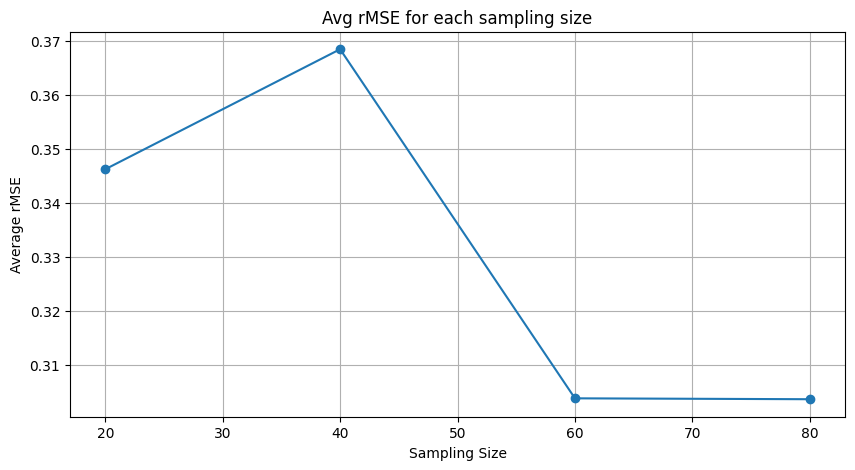

In [ ]:
averages_random = {}  # This will store the average for each key

for key, values in test_result2.items():
    average = sum(values) / len(values)  # Calculate the average
    averages_random[key] = average  # Store the average in the new dictionary

print(averages_random)

import matplotlib.pyplot as plt

# Prepare the data for plotting
keys = list(averages_random.keys())
values = list(averages_random.values())

# Creating the line graph
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(keys, values, marker='o')  # Plot lines with markers at each data point
plt.title('Avg rMSE for each sampling size')  # Add a title
plt.xlabel('Sampling Size')  # X-axis label
plt.ylabel('Average rMSE')  # Y-axis label
plt.grid(True)  # Turn on the grid
plt.show()  # Display the plot



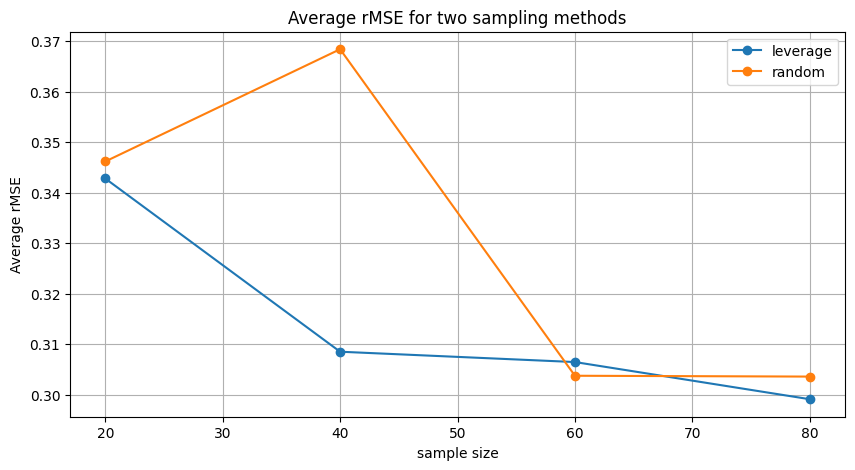

In [ ]:
import matplotlib.pyplot as plt

# Data preparation
keys = list(averages.keys())  # This assumes both dictionaries have the same keys
values = list(averages.values())
values_random = list(averages_random.values())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(keys, values, marker='o', label='leverage')  # Plot first set of data
plt.plot(keys, values_random, marker='o', label='random')  # Plot second set of data

# Adding title and labels
plt.title('Average rMSE for two sampling methods')
plt.xlabel('sample size')
plt.ylabel('Average rMSE')
plt.grid(True)
plt.legend()  # This adds the legend to differentiate the two lines
plt.show()

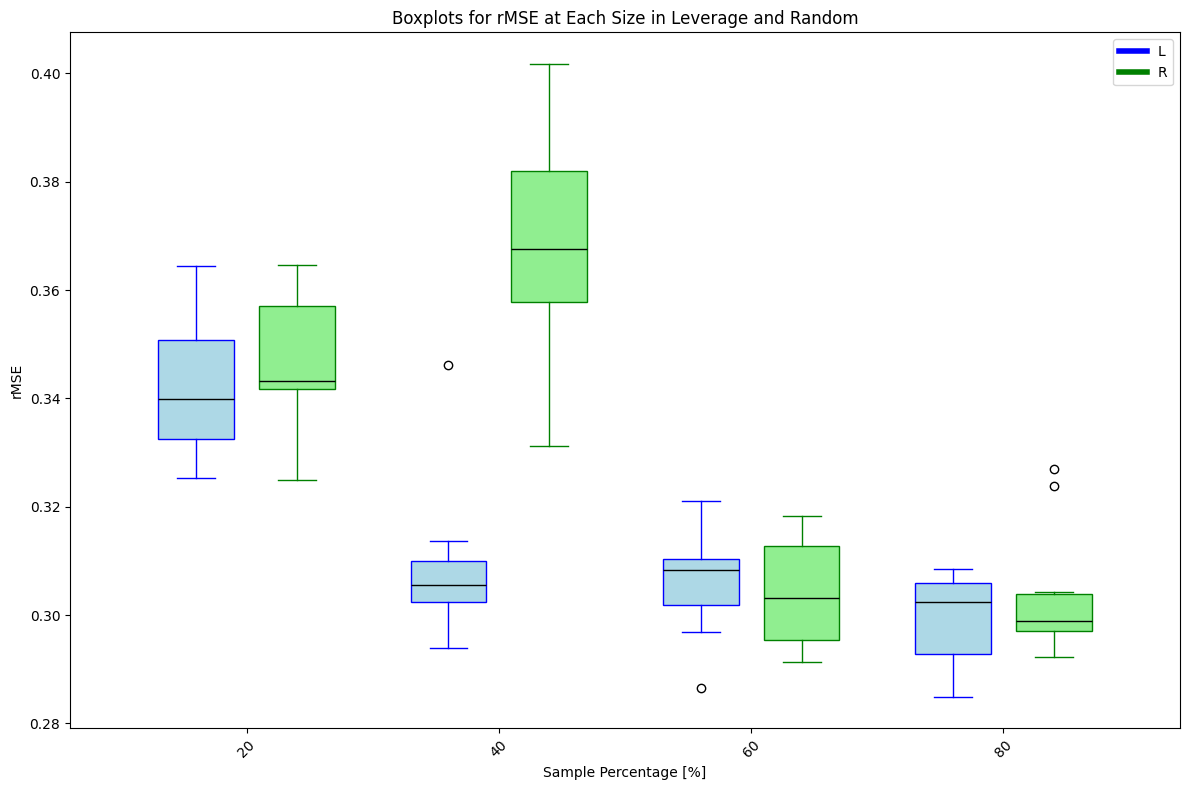

In [ ]:
keys = test_result.keys()  # Extract keys from _result
data_to_plot = []

# Pair values for plotting
for key in keys:
    values_from_result = test_result[key]
    values_from_result2 = test_result2[key]
    data_to_plot.append((key, values_from_result, values_from_result2))

plt.figure(figsize=(12, 8))

# Define colors
colors = ['lightblue', 'lightgreen']

for i, (key, values_result, values_result2) in enumerate(data_to_plot, 1):
    # Boxplot for _result
    bplot1 = plt.boxplot(
        [values_result],
        positions=[i - 0.2],  # Slightly offset to the left
        widths=0.3,
        patch_artist=True,  # Enable patch customization
        boxprops=dict(facecolor=colors[0], color='blue'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue'),
    )

    # Boxplot for result2
    bplot2 = plt.boxplot(
        [values_result2],
        positions=[i + 0.2],  # Slightly offset to the right
        widths=0.3,
        patch_artist=True,  # Enable patch customization
        boxprops=dict(facecolor=colors[1], color='green'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='green'),
        capprops=dict(color='green'),
    )

# Labels and layout
plt.title("Boxplots for rMSE at Each Size in Leverage and Random")
plt.xlabel("Sample Percentage [%]")
plt.ylabel("rMSE")
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='blue', lw=4, label='L'),
        plt.Line2D([0], [0], color='green', lw=4, label='R')
    ],
    loc="upper right"
)
plt.tight_layout()
plt.show()